In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import captum
from utils import *
from models.cnn import CNN
from torchvision import transforms
from torchvision.transforms import ToTensor
%matplotlib inline

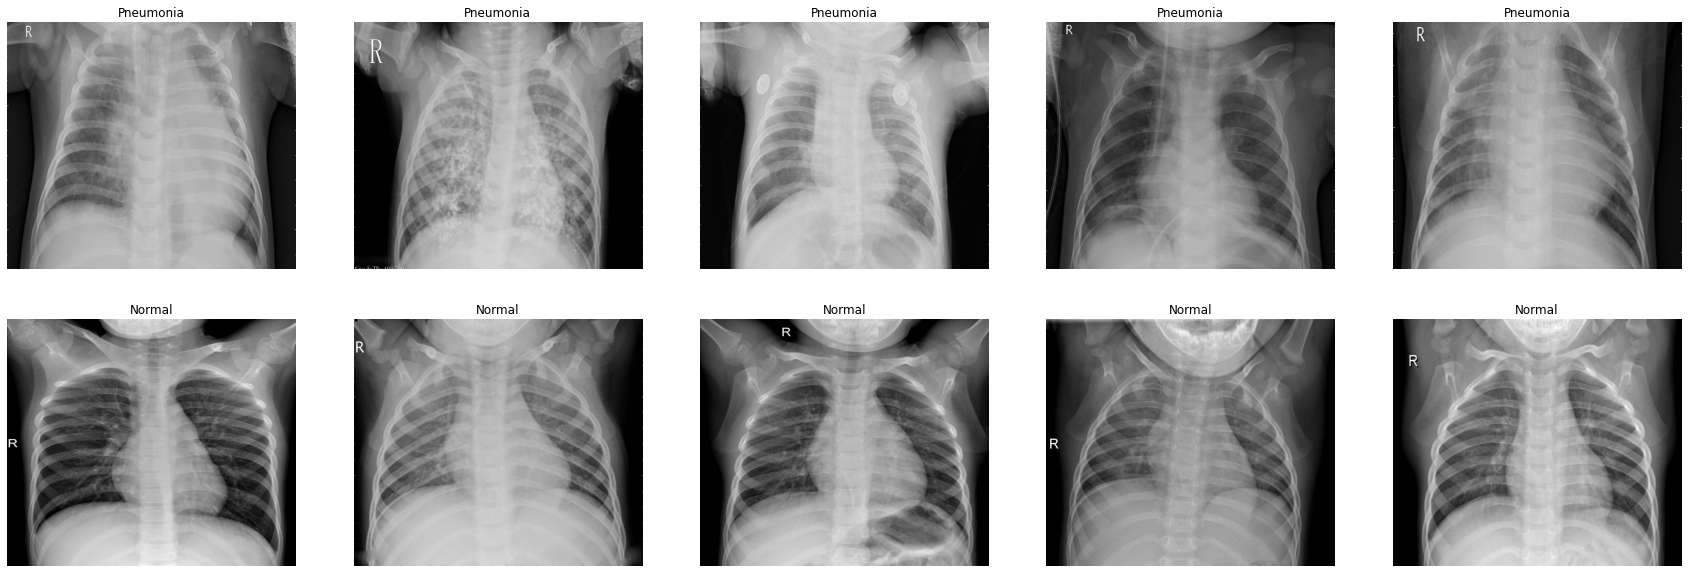

In [12]:
dataset = get_data()
pneumonia_samples = dataset[dataset['class']==1]['filename'].iloc[:5]
normal_samples = dataset[dataset['class']==0]['filename'].iloc[:5]

samples = pd.concat([pneumonia_samples, normal_samples]).to_list()

_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

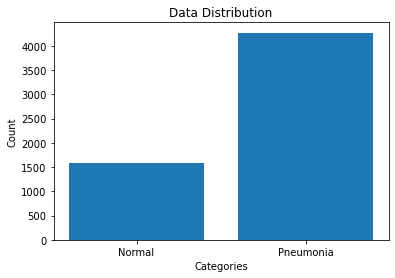

In [13]:
# Plot Image Distribution
categories = ['Normal', 'Pneumonia']
frequencies = list(dataset['class'].value_counts())[::-1]
plt.bar(categories, frequencies)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title(f'Data Distribution')
plt.show()

In [14]:
train_split = dataset.iloc[:round(len(dataset) * 0.8)]
val_split = dataset.iloc[round(len(dataset) * 0.8): round(len(dataset) * 0.9)]
test_split = dataset.iloc[round(len(dataset) * 0.9):]

In [15]:
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.00175
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using the {DEVICE.type}')

Using the cpu


In [16]:
class ImgDataset(Dataset):
    def __init__(self, df, img_size=(28, 28), transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        self.img_size = img_size
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

In [17]:
data_transforms = transforms.Compose([
    ToTensor(),
    transforms.RandomAffine(degrees=0, shear=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [18]:
train_dataset = ImgDataset(train_split, transform=data_transforms)
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)

val_dataset = ImgDataset(val_split, transform=ToTensor())
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

test_dataset = ImgDataset(test_split, transform=ToTensor())
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(DEVICE), y.float().to(DEVICE)
        pred = model(X).flatten()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.float().to(DEVICE)
            pred = model(X).flatten()
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.001f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
model = CNN().to(DEVICE)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    evaluate(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.703954  [    0/ 4685]
loss: 0.633937  [  320/ 4685]
loss: 0.461674  [  640/ 4685]
loss: 0.497199  [  960/ 4685]
loss: 0.608621  [ 1280/ 4685]
loss: 0.501724  [ 1600/ 4685]
loss: 0.664729  [ 1920/ 4685]
loss: 0.657637  [ 2240/ 4685]
loss: 0.638817  [ 2560/ 4685]
loss: 0.521075  [ 2880/ 4685]
loss: 0.182731  [ 3200/ 4685]
loss: 0.441386  [ 3520/ 4685]
loss: 0.388029  [ 3840/ 4685]
loss: 0.385987  [ 4160/ 4685]
loss: 0.312944  [ 4480/ 4685]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.332816 

Epoch 2
-------------------------------
loss: 0.397229  [    0/ 4685]
loss: 0.448419  [  320/ 4685]
loss: 0.334088  [  640/ 4685]
loss: 0.308907  [  960/ 4685]
loss: 0.376658  [ 1280/ 4685]
loss: 0.258822  [ 1600/ 4685]
loss: 0.244321  [ 1920/ 4685]
loss: 0.266751  [ 2240/ 4685]
loss: 0.142526  [ 2560/ 4685]
loss: 0.178200  [ 2880/ 4685]
loss: 0.351388  [ 3200/ 4685]
loss: 0.301131  [ 3520/ 4685]
loss: 0.719409  [ 3840/ 4685]
loss: 0.417390  [ 4160/ 4685

In [29]:
print('''Test Error: 
 Accuracy: 94.0%, Avg loss: 0.172943 
''')

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.172943 



In [25]:
evaluate(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.172943 



In [26]:
PATH = './model.pth'
saved_model = torch.save(model, PATH)

In [27]:
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64, out_features=512, bias=True)
    (14): Linear(in_features=512, out_features=1, bias=True)
    (15): Sigmoid()
  )
)
